# Isochrones

How far can I walk in 1, 5, 10, 15 and 20 minutes, starting from a specified point?
This can indicate irregularities in the urban structure. 

In [1]:
import common_options as co
import matplotlib.cm as cm
import matplotlib.colors as colors
import networkx as nx
import osmnx as ox
import pandas as pd
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__


'1.1.0'

In [2]:
coords_starting = (48.19376, 16.32193) # Starting point for walk time calculations

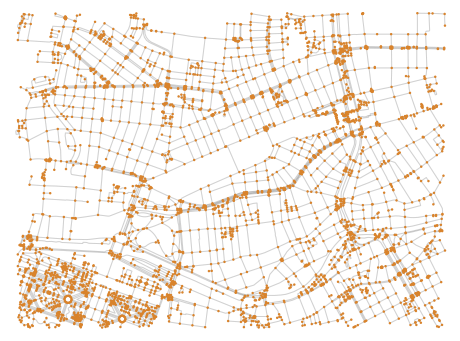

In [3]:
G = ox.graph_from_bbox(*co.bb_westbahnhofareal, clean_periphery=True, custom_filter=co.walking_filter_wbh, **co.graph_download_options)
fig, ax = ox.plot_graph(G, **co.graph_plot_nodes_options)

In [4]:
# based on https://github.com/gboeing/osmnx-examples/blob/v1.0.1/notebooks/13-isolines-isochrones.ipynb

from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt

center_node = ox.nearest_nodes(G, [coords_starting[1]], [coords_starting[0]])[0]
G = ox.project_graph(G)

travel_speed = 5 #walking speed in km/hour

meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute



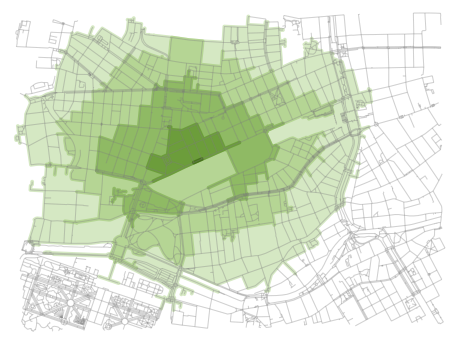

In [5]:
trip_times = [1, 5, 10, 15, 20] #in minutes

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time', undirected=True)

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=15, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, **co.graph_plot_options)
for polygon, fc in zip(isochrone_polys, co.col_greens_5):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.savefig('figures/isochrones.svg')
plt.savefig('figures/isochrones.png', bbox_inches='tight')